In [1]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot

from pathlib import Path
from functools import reduce
from datetime import datetime

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [13]:
df = pd.read_csv('./../final_dfs/for_modeling/df_final_date_wide_2007.csv', converters={'ags2': str, 'ags5': str} )
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])
df.set_index('ags5', drop=True, inplace=True)
df = df.drop("Unnamed: 0", axis=1)
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
#df = df[(df['date'] >= '2010-01-01') & (df['date'] < '2020-01-01')]
df

,ags2,date,number_of_company_deletions,number_of_company_liquidations,number_of_start_ups,number_of_companies_administration,number_of_companies_agriculture,number_of_companies_arts_entertainment,number_of_companies_communication,number_of_companies_construction,...,realized_short_time_work_companies,realized_short_time_work_people,underemployment_without_short_time _work,unemployment_benefit_entitled,unemployment_benefit_recipients,unemployment_rate,registerd_jobs,unemployed,employees_social_security_at_work,employees_social_security_at_residence
ags5,,,,,,,,,,,,,,,,,,,,,
01001,1,2007-05-01,4.0,2.0,21.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.7,784,5559,38319,24519
01001,1,2007-06-01,8.0,6.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.2,932,5323,38266,24560
01001,1,2007-07-01,9.0,0.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.5,862,5454,38237,24561
01001,1,2007-08-01,6.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.3,819,5377,38833,24936
01001,1,2007-09-01,11.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.7,725,5132,38840,25072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16077,16,2020-07-01,2.0,1.0,5.0,114.0,100.0,122.0,44.0,457.0,...,311.0,2709.0,4505.0,6661.0,1022.0,7.2,664,3242,27356,33148
16077,16,2020-08-01,1.0,1.0,4.0,114.0,100.0,121.0,44.0,457.0,...,264.0,2104.0,4432.0,6653.0,1024.0,7.3,692,3271,27490,33287
16077,16,2020-09-01,1.0,0.0,5.0,114.0,100.0,121.0,44.0,455.0,...,224.0,1750.0,4277.0,6473.0,970.0,7.0,806,3129,27765,33583


In [14]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df2.set_index('ags5', drop=True, inplace=True)
df = pd.merge(df, df2[['bundesland','kreis']], left_index = True, right_index = True)
df

,ags2,date,number_of_company_deletions,number_of_company_liquidations,number_of_start_ups,number_of_companies_administration,number_of_companies_agriculture,number_of_companies_arts_entertainment,number_of_companies_communication,number_of_companies_construction,...,underemployment_without_short_time _work,unemployment_benefit_entitled,unemployment_benefit_recipients,unemployment_rate,registerd_jobs,unemployed,employees_social_security_at_work,employees_social_security_at_residence,bundesland,kreis
ags5,,,,,,,,,,,,,,,,,,,,,
01001,1,2007-05-01,4.0,2.0,21.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.7,784,5559,38319,24519,Schleswig-Holstein,"Flensburg, Stadt"
01001,1,2007-06-01,8.0,6.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.2,932,5323,38266,24560,Schleswig-Holstein,"Flensburg, Stadt"
01001,1,2007-07-01,9.0,0.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.5,862,5454,38237,24561,Schleswig-Holstein,"Flensburg, Stadt"
01001,1,2007-08-01,6.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.3,819,5377,38833,24936,Schleswig-Holstein,"Flensburg, Stadt"
01001,1,2007-09-01,11.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11.7,725,5132,38840,25072,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16077,16,2020-07-01,2.0,1.0,5.0,114.0,100.0,122.0,44.0,457.0,...,4505.0,6661.0,1022.0,7.2,664,3242,27356,33148,Thüringen,Altenburger Land
16077,16,2020-08-01,1.0,1.0,4.0,114.0,100.0,121.0,44.0,457.0,...,4432.0,6653.0,1024.0,7.3,692,3271,27490,33287,Thüringen,Altenburger Land
16077,16,2020-09-01,1.0,0.0,5.0,114.0,100.0,121.0,44.0,455.0,...,4277.0,6473.0,970.0,7.0,806,3129,27765,33583,Thüringen,Altenburger Land


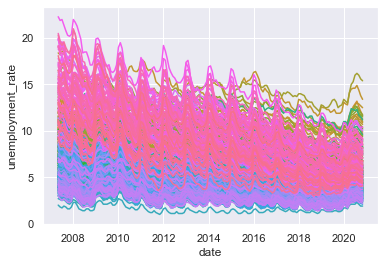

In [15]:
g = sns.lineplot(data=df, x="date", y="unemployment_rate",  hue="ags5")
g.legend_.remove()